In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

### Load in Data

In [2]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

    # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (180000, 20000, 0)


### Load in Both Models

In [3]:
from model import *
from utils import *
from transformer import *
unet = UNet1D()
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/unet_2_2_35epochs.pth", weights_only=True)
unet.load_state_dict(checkpoint['model_state_dict'])
unet = unet.to('cuda')  # move model to GPU if needed
unet.eval()

UNet1D(
  (encoders): ModuleList(
    (0): Sequential(
      (0): ResidualBlock1D(
        (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualBlock1D(
        (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): ResidualBlock1D(
        (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), p

In [4]:
transformer = TransformerModel()
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/transformer_28_49.pth", weights_only=True)
transformer.load_state_dict(checkpoint['model_state_dict'])
transformer = transformer.to('cuda')  # move model to GPU if needed
transformer.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerModel(
  (tokenizer): Conv1d(1, 48, kernel_size=(100,), stride=(100,))
  (positional_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
        )
        (linear1): Linear(in_features=48, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=48, bias=True)
        (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (upsample): Linear(in_features=48, out_features=48, bias=True)
  (class_l1): Conv1d(48, 24, kernel_size=(1,), stride=(1,))
  (class_l2): Conv1d(24, 1, kernel_size=(1,), 

### Plotting

In [5]:
waveform_batch_id = 10
device = 'cuda'
val_iter = iter(val_loader)
print(len(val_loader))

for i in range(1):  # first two batches
    waveforms, arrival_times, hit_times, photon_target, photon_list = next(val_iter)
    print(f"Batch {i} has waveforms shape {waveforms.shape}")
    
waveforms = waveforms.to(device)
wf = waveforms[waveform_batch_id]
unet_class_output, unet_reg_output = unet(waveforms)
trans_class_output, trans_reg_output = transformer(waveforms)
ticks = np.arange(wf.shape[1])

epoch = 6
loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(waveforms, hit_times, photon_list, unet_class_output, unet_reg_output, epoch, device)
t_loss, t_sampled_indices, t_masked_target, t_masked_output, t_output, t_target, t_masked_reg_output, t_masked_photon_target = mined_bce_loss(waveforms, hit_times, photon_list, trans_class_output, trans_reg_output, epoch, device)

/lscratch/carsmith/tmp/ipykernel_1404757/344282368.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hit_times = torch.tensor(hit_times)


800
Batch 0 has waveforms shape torch.Size([25, 1, 8000])


In [6]:
# Predicted hits
unet_class_output = unet_class_output.squeeze(1)
trans_class_output = trans_class_output.squeeze(1)
unet_mask = torch.sigmoid(unet_class_output[waveform_batch_id, :]) > 0.5
trans_mask = torch.sigmoid(trans_class_output[waveform_batch_id, :]) > 0.5
unet_pred_hits = torch.nonzero(unet_mask, as_tuple=False).squeeze(1)
trans_pred_hits = torch.nonzero(trans_mask, as_tuple=False).squeeze(1)

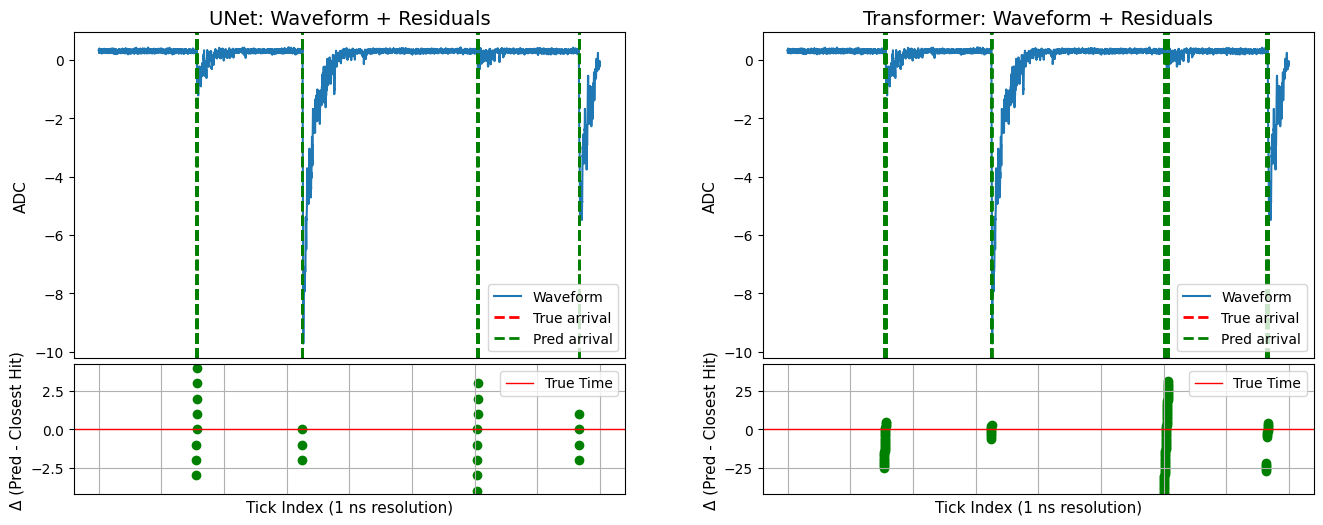

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_residuals_side_by_side(wf, ticks, hit_times, waveform_batch_id,
                                unet_pred_hits, trans_pred_hits):
    fig = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[5, 2], hspace=0.025, wspace=0.25)

    # ---- UNet panels (left column) ----
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

    # ---- Transformer panels (right column) ----
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)

    # ========== Helper plotting function ==========
    def plot_one(ax_top, ax_bottom, pred_hits, title):
        ax_top.set_title(title, fontsize=14)

        # Top panel: waveform + hits
        ax_top.plot(ticks, wf.squeeze(0).cpu(), alpha=1, label='Waveform')

        true_ints = [int(t) for t in hit_times[waveform_batch_id]]
        for j, t in enumerate(true_ints):
            if t >= 0:
                ax_top.axvline(
                    x=t, color='r', linestyle='--', linewidth=2,
                    label='True arrival' if j == 0 else None
                )

        for j, t in enumerate(pred_hits):
            ax_top.axvline(
                x=t.item(), color='g', linestyle='--', linewidth=2,
                label='Pred arrival' if j == 0 else None
            )

        pred_ints = [int(t.item()) for t in pred_hits]
        deltas = []
        for p in pred_ints:
            # find closest true hit
            closest_true = min(true_ints, key=lambda t: abs(t - p))
            delta_val = p - closest_true
            deltas.append((p, delta_val))

        # Bottom panel: residuals
        pred_ticks, delta_vals = zip(*deltas) if deltas else ([], [])
        ax_bottom.axhline(0, color='r', linestyle='-', linewidth=1, label='True Time')
        ax_bottom.scatter(pred_ticks, delta_vals, color='g', marker='o')
        ax_bottom.set_ylabel("Δ (Pred - Closest Hit)", fontsize=11)
        range_lim = max(abs(np.min(delta_vals)), abs(np.max(delta_vals))) if delta_vals else 1
        ax_bottom.set_ylim(-range_lim - 0.25, range_lim + 0.25)
        ax_bottom.grid()
        ax_bottom.set_xlabel("Tick Index (1 ns resolution)", fontsize=11)
        ax_bottom.legend()

        # Labels and ticks
        ax_top.legend()
        ax_top.set_ylabel("ADC", fontsize=11)

        # Remove x ticks on top
        ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax_bottom.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # Make tick labels readable
        for ax in [ax_top, ax_bottom]:
            ax.tick_params(axis='both', which='major', labelsize=10)

    # ---- Apply to UNet ----
    plot_one(ax0, ax1, unet_pred_hits, "UNet: Waveform + Residuals")
    
    # ---- Apply to Transformer ----
    plot_one(ax2, ax3, trans_pred_hits, "Transformer: Waveform + Residuals")
    
    plt.show()
    
plot_residuals_side_by_side(
    wf, ticks, hit_times, waveform_batch_id,
    unet_pred_hits, trans_pred_hits
)

### Evaluating Accuracy & Purity

In [8]:
from hybrid_loss import *

epochs = 1
epoch = 0

acc_progress = tqdm(train_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))

# Accumulators for UNet
unet_acc = 0.0
unet_pure = 0.0
unet_merge_acc = 0.0
unet_merge_pure = 0.0

# Accumulators for Transformer
trans_acc = 0.0
trans_pure = 0.0
trans_merge_acc = 0.0
trans_merge_pure = 0.0

unet_interval_bins = []
trans_interval_bins = []

with torch.no_grad():
    for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
        data, target, photon_target = data.to(device), target.to(device), photon_target.to(device) # [B, 1, 16000]

        # Forward passes
        unet_class_output, unet_reg_output = unet(data, mode='bce')
        trans_class_output, trans_reg_output = transformer(data, mode='bce')

        # Masks for merged evaluation
        unet_merged_mask = merge_bins(unet_class_output)
        trans_merged_mask = merge_bins(trans_class_output)

        # Interval widths (UNet)
        for b in range(unet_merged_mask.shape[0]):
            mask_row = unet_merged_mask[b, 0]  # [L]
            intervals = mask_to_intervals(mask_row)
            widths = [(e - s + 1) for (s, e) in intervals]
            unet_interval_bins.extend(widths)

        # Interval widths (Transformer)
        for b in range(trans_merged_mask.shape[0]):
            mask_row = trans_merged_mask[b, 0]
            intervals = mask_to_intervals(mask_row)
            widths = [(e - s + 1) for (s, e) in intervals]
            trans_interval_bins.extend(widths)

        # ---- UNet stats ----
        unet_acc += overall_class_acc(hit_times, unet_class_output, device)
        unet_merge_acc += merged_class_acc(unet_merged_mask, hit_times, device)
        unet_pure += overall_class_purity(hit_times, unet_class_output, device)
        unet_merge_pure += merged_class_purity(unet_merged_mask, hit_times, device)

        # ---- Transformer stats ----
        trans_acc += overall_class_acc(hit_times, trans_class_output, device)
        trans_merge_acc += merged_class_acc(trans_merged_mask, hit_times, device)
        trans_pure += overall_class_purity(hit_times, trans_class_output, device)
        trans_merge_pure += merged_class_purity(trans_merged_mask, hit_times, device)

        # ---- Compute avg interval widths ----
        avg_unet_interval = np.mean(unet_interval_bins) if unet_interval_bins else 0.0
        avg_trans_interval = np.mean(trans_interval_bins) if trans_interval_bins else 0.0


# ---- Average across batches ----
N = len(train_loader)

unet_acc /= N
unet_pure /= N
unet_merge_acc /= N
unet_merge_pure /= N

trans_acc /= N
trans_pure /= N
trans_merge_acc /= N
trans_merge_pure /= N

# ---- Print results ----
print("=== UNet Statistics ===")
print(f"Overall Classification Accuracy: {unet_acc:.4f}")    
print(f"Overall Classification Purity:   {unet_pure:.4f}")
print(f"Merged Classification Accuracy:  {unet_merge_acc:.4f}") 
print(f"Merged Classification Purity:    {unet_merge_pure:.4f}")
print(f"Avg. Merged Interval Width (bins): {avg_unet_interval:.2f}")

print("\n=== Transformer Statistics ===")
print(f"Overall Classification Accuracy: {trans_acc:.4f}")    
print(f"Overall Classification Purity:   {trans_pure:.4f}")
print(f"Merged Classification Accuracy:  {trans_merge_acc:.4f}") 
print(f"Merged Classification Purity:    {trans_merge_pure:.4f}")
print(f"Avg. Merged Interval Width (bins): {avg_trans_interval:.2f}")

=== UNet Statistics ===
Overall Classification Accuracy: 0.9278
Overall Classification Purity:   0.1898
Merged Classification Accuracy:  0.9326
Merged Classification Purity:    0.9486
Avg. Merged Interval Width (bins): 6.62

=== Transformer Statistics ===
Overall Classification Accuracy: 0.9610
Overall Classification Purity:   0.0441
Merged Classification Accuracy:  0.9616
Merged Classification Purity:    0.7053
Avg. Merged Interval Width (bins): 23.13


In [9]:
loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(waveforms, hit_times, photon_list, unet_class_output, unet_reg_output, epoch, device)

def sampled_acc(sampled_indices, output, target):
    """
    Check if predictions (sigmoid > 0.5 → 1, else 0) match the target at sampled indices.
    """
    preds = (torch.sigmoid(output) > 0.5).long().squeeze(1)
    matches = (preds[sampled_indices] == target[sampled_indices])
    return matches.float().mean().item()


acc_progress = tqdm(train_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

acc = 0.0
for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
    data, target, photon_target = data.to(device), target.to(device), photon_target.to(device) # [B, 1, 16000]
    class_output, reg_output = transformer(data)
    loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(data, hit_times, photon_list, class_output, reg_output, epoch, device)
    acc += sampled_acc(sampled_indices, output, target)

print(f"Sampled accuracy: {acc / len(train_loader):.3f}")

KeyboardInterrupt: 